## Installation via conda

1.conda create --name gwr python=3.6 matplotlib numpy pandas scipy jupyter jupyterlab

2.conda install --name gwr fiona=1.8.13

3.conda install --name gwr geopandas=0.8.1

4.conda install -c conda-forge --name gwr libpysal spglm esda maplcassify

5.conda install -c conda-forge --name gwr mgwr 

In [ ]:
import numpy as np
import pandas as pd
import libpysal as ps
import esda
import mapclassify as mc

import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

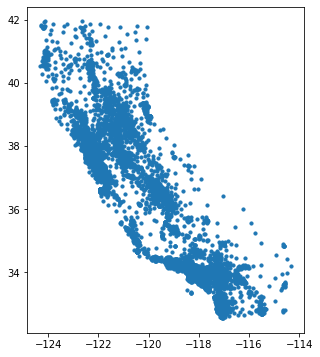

In [14]:
#Load dataset and generate plot of properties
house = gp.read_file(r'...')

fig, ax = plt.subplots(figsize = (6, 6))
house.plot(ax = ax, markersize = 10, marker='o')
plt.show()

In [15]:
print(house.head(3))
house.dtypes

   houseValue  income  houseAge  rooms  bedrooms  population  households  \
0      452600  8.3252        41    880       129         322         126   
1      358500  8.3014        21   7099      1106        2401        1138   
2      352100  7.2574        52   1467       190         496         177   

   latitude  longitude                     geometry  
0     37.88    -122.23  POINT (-122.23000 37.88000)  
1     37.86    -122.22  POINT (-122.22000 37.86000)  
2     37.85    -122.24  POINT (-122.24000 37.85000)  


houseValue       int64
income         float64
houseAge         int64
rooms            int64
bedrooms         int64
population       int64
households       int64
latitude       float64
longitude      float64
geometry      geometry
dtype: object

In [16]:
house['roomsAVG']= house['rooms'] / house['households']
house['bedroomsAVG'] = house['bedrooms'] / house['households'] 

In [17]:
house=house.drop(columns=['rooms', 'bedrooms'])
print(house.head(3))

   houseValue  income  houseAge  population  households  latitude  longitude  \
0      452600  8.3252        41         322         126     37.88    -122.23   
1      358500  8.3014        21        2401        1138     37.86    -122.22   
2      352100  7.2574        52         496         177     37.85    -122.24   

                      geometry  roomsAVG  bedroomsAVG  
0  POINT (-122.23000 37.88000)  6.984127     1.023810  
1  POINT (-122.22000 37.86000)  6.238137     0.971880  
2  POINT (-122.24000 37.85000)  8.288136     1.073446  


In [18]:
# Split data into calibration (train) and prediction (test) sets

train=house.sample(frac=0.8,random_state=200) #random state is a seed value
test=house.drop(train.index)

print(train.shape)
print(test.shape)

(16512, 10)
(4128, 10)


In [24]:
#Prepare dataset inputs

#Train
cal_y = train['houseValue'].values.reshape((-1, 1)) 
cal_X = train[['income','houseAge', 'roomsAVG','bedroomsAVG','population', 'households']].values

u = train['latitude']
v = train['longitude']
cal_coords = list(zip(u, v))

#Test
#pred_y = np.log(test['zinc'].values.reshape((-1, 1)))
pred_y = test['houseValue'].values.reshape((-1, 1)) #check without the log...
pred_X = test[['income','houseAge', 'roomsAVG','bedroomsAVG','population', 'households']].values

y = test['latitude']
z = test['longitude']
p_coords = list(zip(y, z))
pred_coords = np.array(p_coords)

In [25]:
# Bandwidth Selection 
#(takes time...)

#Instantiate bandwidth selection object
selector = Sel_BW(cal_coords, cal_y, cal_X, spherical = True)

#Default golden section search using AICc criterion
bw = selector.search()
print(bw)

71.0


In [26]:
#Fit GWR model
model = GWR(cal_coords, cal_y, cal_X, bw)
gwr_results = model.fit()
#Global  diagnostics
print(gwr_results.resid_ss)
print(gwr_results.aic)
print(gwr_results.aicc)
print(gwr_results.R2)

#Make predictions
pred_results = model.predict(pred_coords, pred_X)

#Check correlation between known and predicted values
corr = np.corrcoef(pred_results.predictions.flatten(),pred_y.flatten())[0][1]
print('correlation between known and predicted values of test dataset',corr)

17491795914501.135
397644.2748132687
399952.05006370094
0.9209830891352205
correlation between known and predicted values of test dataset 0.9047071577900053


In [28]:
#Calculation of TEST ERROR 
test['predictions']=pred_results.predictions.flatten()
test['pred_y']=pred_y.flatten()
test['test_res']=test['pred_y']-test['predictions']

def rmse(x):
    return np.sqrt(((x) ** 2).mean())

rmse_test = rmse(test['test_res'])
print("rmse error of test data is: " + str(rmse_test))
print(test.shape)

rmse error of test data is: 49077.10448938747
(4128, 13)


In [30]:
# Model fit all data!
#Prepare dataset inputs

h_y = house['houseValue'].values.reshape((-1, 1)) 
h_X = house[['income','houseAge', 'roomsAVG','bedroomsAVG','population', 'households']].values

a = house['latitude']
b = house['longitude']
h_coords = list(zip(a, b))

In [31]:
# Bandwidth Selection 

#Instantiate bandwidth selection object
selector1 = Sel_BW(h_coords, h_y, h_X, spherical = True)

#Default golden section search using AICc criterion
bw1 = selector1.search()
print(bw1)

80.0


In [32]:
#Fit GWR model
model_all = GWR(h_coords, h_y, h_X, bw1)
gwr_results1 = model_all.fit()

#Global  diagnostics
print(gwr_results1.resid_ss)
print(gwr_results1.aic)
print(gwr_results1.aicc)
print(gwr_results1.R2)

house['res'] = gwr_results1.resid_response
rmse_all = rmse(house['res'])
print("rmse error of model all data is: " + str(rmse_all), '(this is the training error to be used in the paper)')
print(house.shape)

21688343494744.23
495928.895675244
498195.2913903112
0.9210850813580898
rmse error of model all data is: 32415.9194838843 (this is the training error to be used in the paper)
(20640, 11)


In [20]:
# Inference on Individual Parameter Estimates

# hypothesis tests for significance of parameter estimates
#default behavior using corrected alpha
filter_t = gwr_results1.filter_tvals()

# estimated coefficients & significance for income
house['income_params'] = gwr_results1.params[:, 1]
house['income_params_stand']=  house['income_params'] * ( house['income'].std()/ house['houseValue'].std())  
print ('mean absolute standardised of income parameters',house['income_params_stand'].apply(abs).mean())

house['income_t'] = filter_t[:, 1]
insig_income = house[house['income_t']> 0.05]['income_t']
print ('number of income insigificant parameters', len(insig_income.index))

# estimated coefficients & significance for houseAge
house['houseAge_params'] = gwr_results1.params[:, 2] #params = n*k, estimated coefficients
house['houseAge_params_stand']=  house['houseAge_params'] * ( house['houseAge'].std()/ house['houseValue'].std())  
print ('mean absolute standardised of houseAge parameters',house['houseAge_params_stand'].apply(abs).mean())

house['houseAge_t'] = filter_t[:, 2]
insig_houseAge = house[house['houseAge_t']> 0.05]['houseAge_t']
print ('number of houseAge insigificant parameters', len(insig_houseAge.index))

# estimated coefficients & significance for room
house['room_params'] = gwr_results1.params[:, 3]
house['room_params_stand']=  house['room_params'] * ( house['rooms'].std()/ house['houseValue'].std())  
print ('mean absolute standardised of room parameters',house['room_params_stand'].apply(abs).mean())

house['room_t'] = filter_t[:, 3]
insig_room = house[house['room_t']> 0.05]['room_t']
print ('number of room insigificant parameters', len(insig_room.index))

# estimated coefficients & significance for bedrooms
house['bedroom_params'] = gwr_results1.params[:, 4]
house['bedroom_params_stand']=  house['bedroom_params'] * ( house['bedrooms'].std()/ house['houseValue'].std())  
print ('mean absolute standardised of bedroom parameters',house['bedroom_params_stand'].apply(abs).mean())

house['bedrooms_t'] = filter_t[:, 4]
insig_bedrooms = house[house['bedrooms_t']> 0.05]['bedrooms_t']
print ('number of bedrooms insigificant parameters', len(insig_bedrooms.index))

# estimated coefficients & significance for population
house['population_params'] = gwr_results1.params[:, 5]
house['population_params_stand']=  house['population_params'] * ( house['population'].std()/ house['houseValue'].std())  
print ('mean absolute standardised of population parameters',house['population_params_stand'].apply(abs).mean())

house['population_t'] = filter_t[:, 5]
insig_population = house[house['population_t']> 0.05]['population_t']
print ('number of population insigificant parameters', len(insig_population.index))

# estimated coefficients & significance for households
house['households_params'] = gwr_results1.params[:, 6] #params = n*k, estimated coefficients
house['households_params_stand']=  house['households_params'] * ( house['households'].std()/ house['houseValue'].std())  
print ('mean absolute standardised of households parameters',house['households_params_stand'].apply(abs).mean())

house['households_t'] = filter_t[:, 6]
insig_households = house[house['households_t']> 0.05]['households_t']
print ('number of households insigificant parameters', len(insig_households.index))

house.head(2)

mean absolute standardised of income parameters 0.3058161202363251
number of income insigificant parameters 5814
mean absolute standardised of houseAge parameters 0.12252330694100332
number of houseAge insigificant parameters 940
mean absolute standardised of room parameters 0.6411467043092367
number of room insigificant parameters 2013
mean absolute standardised of bedroom parameters 0.6701680698957796
number of bedrooms insigificant parameters 254
mean absolute standardised of population parameters 0.5020202695567401
number of population insigificant parameters 143
mean absolute standardised of households parameters 0.6560060261205026
number of households insigificant parameters 104


,houseValue,income,houseAge,rooms,bedrooms,population,households,latitude,longitude,geometry,...,room_t,bedroom_params,bedroom_params_stand,bedrooms_t,population_params,population_params_stand,population_t,households_params,households_params_stand,households_t
0,452600,8.3252,41,880,129,322,126,37.88,-122.23,POINT (-122.23000 37.88000),...,0.0,-327.758463,-1.196472,0.0,10.240491,0.100497,0.000000,197.281770,0.653636,0.0
1,358500,8.3014,21,7099,1106,2401,1138,37.86,-122.22,POINT (-122.22000 37.86000),...,0.0,-8.016221,-0.029263,0.0,78.231330,0.767742,4.254137,-386.682457,-1.281160,0.0


In [67]:
# Exclude insignificant coefficients
house ['bedroom_params_stand1'] = house ['bedrooms_t']
house.loc[house['bedroom_params_stand1'] > 0.05, 'bedroom_params_stand1'] = np.nan
house.loc[house['bedroom_params_stand1'] <= 0.05, 'bedroom_params_stand1'] = house ['bedroom_params_stand']

house ['population_params_stand1'] = house ['population_t']
house.loc[house['population_params_stand1'] > 0.05, 'population_params_stand1'] = np.nan
house.loc[house['population_params_stand1'] <= 0.05, 'population_params_stand1'] = house ['population_params_stand']
house.head(3)

,houseValue,income,houseAge,rooms,bedrooms,population,households,latitude,longitude,geometry,...,population_params_stand,population_t,households_params,households_params_stand,households_t,Is,pvalue,group,bedroom_params_stand1,population_params_stand1
0,452600,8.3252,41,880,129,322,126,37.88,-122.23,POINT (-122.23000 37.88000),...,0.100497,0.000000,197.281770,0.653636,0.0,0.696282,0.001,hotspot,-1.196472,0.100497
1,358500,8.3014,21,7099,1106,2401,1138,37.86,-122.22,POINT (-122.22000 37.86000),...,0.767742,4.254137,-386.682457,-1.281160,0.0,-0.111625,0.196,not-significant,-0.029263,NaN
2,352100,7.2574,52,1467,190,496,177,37.85,-122.24,POINT (-122.24000 37.85000),...,1.374558,7.862428,-424.708202,-1.407147,0.0,-1.764077,0.003,cold outlier,1.027143,NaN


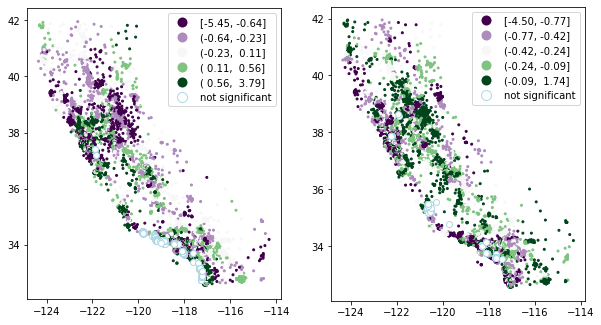

In [97]:
#Map coefficients
fig, axes = plt.subplots(nrows=1, ncols=2,figsize= (10, 7))
house.plot(column='bedroom_params_stand1', scheme='Quantiles', k=5, markersize=4, 
           cmap='PRGn', legend=True,
           missing_kwds={"color": "white",
        "edgecolor": "lightblue","label": "not significant",},
           ax=axes[0])
house.plot(column='population_params_stand1', scheme='Quantiles', k=5, markersize=4, 
           cmap='PRGn', legend=True,
           missing_kwds={"color": "white",
        "edgecolor": "lightblue","label": "not significant",},
           ax=axes[1])
plt.show()
fig.savefig(r'C:\Users\Rania\Desktop\UW\3.Research\SA_ML_xiaojian\California_coef.png')

<AxesSubplot:>

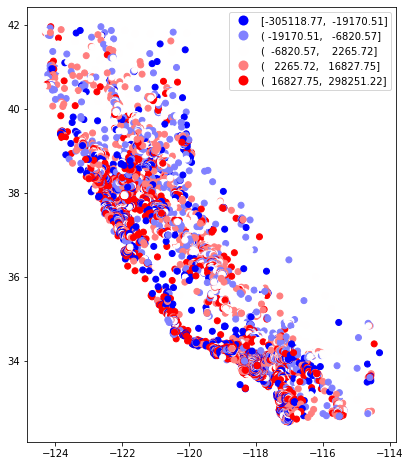

In [35]:
# Global Spatial Autocorrelation
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'aspect':'equal'})
house.plot(column='res', scheme='Quantiles', k=5, cmap='bwr', legend=True, ax=ax)

In [42]:
# The following part creates a spatial weights matrix (wq),
# and based on this the spatial lag operator of the residuals is created too.

wq = ps.weights.distance.KNN.from_dataframe(house, k=15) 
wq.transform = 'r'
y = house['res']
lag_res = ps.weights.lag_spatial(wq, y)

In [44]:
# Calculate Moran's I

mi = esda.Moran(y, wq, permutations = 1000, two_tailed=False)
print( 'Moran I is', round(mi.I, 3), 'and p-value is', mi.p_sim, 'expected value is', mi.EI)

Moran I is 0.016 and p-value is 0.000999000999000999 expected value is -4.845195988177722e-05


In [45]:
# Calculate LISA
lisa = esda.moran.Moran_Local(y, wq)

In [46]:
# Calculate spatial groupings and significance
house['Is'] = lisa.Is
house['pvalue'] = lisa.p_sim 
house['group'] = lisa.q 

house.loc[house['pvalue'] > 0.05, 'group'] = 'not-significant'
house.loc[house['group'] == 1, 'group'] = 'hotspot'
house.loc[house['group'] == 2, 'group'] = 'cold outlier'
house.loc[house['group'] == 3, 'group'] = 'coldspot'
house.loc[house['group'] == 4, 'group'] = 'hot outlier'

print(house ['group'].value_counts())

house.head(2)

not-significant    18566
coldspot             660
hotspot              526
cold outlier         476
hot outlier          412
Name: group, dtype: int64


,houseValue,income,houseAge,population,households,latitude,longitude,geometry,roomsAVG,bedroomsAVG,...,room_t,bedrooms_params,bedrooms_t,population_params,population_t,households_params,households_t,Is,pvalue,group
0,452600,8.3252,41,322,126,37.88,-122.23,POINT (-122.23000 37.88000),6.984127,1.02381,...,0.0,-337847.469524,0.0,12.867009,0.000000,-126.636687,-4.543484,0.760612,0.001,hotspot
1,358500,8.3014,21,2401,1138,37.86,-122.22,POINT (-122.22000 37.86000),6.238137,0.97188,...,0.0,-267144.146280,0.0,97.772804,5.076368,-259.020784,-6.160056,-0.083038,0.296,not-significant


In [50]:
house.to_csv(r'..houses_pred.csv', index=False)

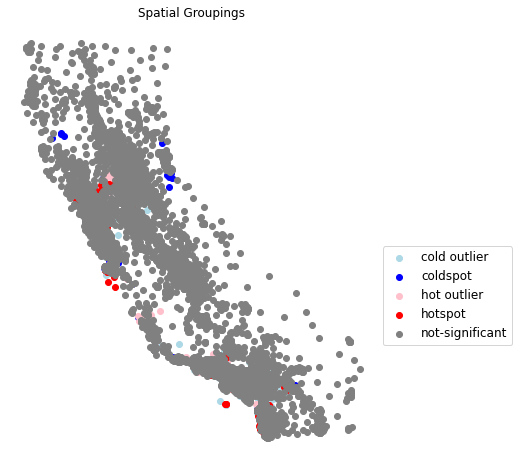

In [51]:
# Vizualize spatial groupings and significance
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'aspect':'equal'})    

group_colors = {'not-significant': 'grey',
               'hotspot': 'red',
               'coldspot': 'blue',
               'cold outlier': 'lightblue',
               'hot outlier': 'pink'}
group_colors

for ctype, data in house.groupby('group'):
    
    # Define the color for each group using the dictionary
    color = group_colors[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color, ax=ax, label=ctype)

ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
ax.set(title='Spatial Groupings')

ax.set_axis_off()
plt.show()
